In [3]:
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


In [4]:
def construct_full_model(hparams):
    '''
    return: nn.Module. Take a sequence of input symbols and 
    return a sequence of output symbols
    '''

    # cloned
    clone = copy.deepcopy
    pff = Positiontwise_FF(d_model=hparams['d_model'], d_ff=hparams['d_ff'])
    attn = MultiHeadAttention(
        d_model=hparams['d_model'], 
        h=hparams['num_heads'], 
        attn_wt_dropout=hparams['attn_wt_dropout'],
        attn_wt_init_tying_scheme=hparams['attn_wt_init_tying_scheme']
    )
    layer_norm = LayerNorm(d_model=hparams['d_model'])
    
    # embeddings
    scaled_embed_X = ScaledEmbedding(hparams['vocab_size'], hparams['d_model'])
    
    position_encoder = LearnedPositionEncoder(
        d_model=hparams['d_model'], 
        max_len=hparams['max_len'],
        emb_init_var=torch.var(scaled_embed_X.embedding.weight).cpu().item()
    )
    
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        encoder_query=Encoder(
            encoder_layer=EncoderLayer(
                poswise_ff=clone(pff),
                self_attn=clone(attn), 
                layer_norm=clone(layer_norm), 
                heads_dropout=hparams['heads_dropout'],
                pff_dropout=hparams['pff_dropout']
            ), 
            N_layers=hparams['N_enc'],
            d_model=hparams['d_model'],
        ),
        encoder_key=Encoder(
            encoder_layer=EncoderLayer(
                poswise_ff=clone(pff),
                self_attn=clone(attn), 
                layer_norm=clone(layer_norm), 
                heads_dropout=hparams['heads_dropout'],
                pff_dropout=hparams['pff_dropout']
            ), 
            N_layers=hparams['N_enc'],
            d_model=hparams['d_model'],
        ),
        inp_query_layer=nn.Sequential(
            OrderedDict([('scaled_embed', scaled_embed_X),
                        ('position_encoder', position_encoder),
                        ('embed_dropout', embed_dropout)]
            )
        ),
        inp_key_layer=nn.Sequential(
            OrderedDict([('scaled_embed', scaled_embed_X),
                        ('position_encoder', position_encoder),
                        ('embed_dropout', embed_dropout)]
            )
        ),
        pad_idx_query=hparams['padding_idx_query'],
        pad_idx_key=hparams['padding_idx_key'],
        repr_pos=hparams['representation_pos']
    )

    return model    

In [5]:
## Code Depth 2

class EncoderPredictor(nn.Module):

    def __init__(self, encoder_query, encoder_key, inp_query_layer, inp_key_layer, pad_idx_query, pad_idx_key, repr_pos):
        super(EncoderPredictor, self).__init__()
        self.encoder_query = encoder_query
        self.encoder_key = encoder_key
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.pad_idx_query = pad_idx_query
        self.pad_idx_key = pad_idx_key
        self.repr_pos = repr_pos
        
    def forward(self, X_query, X_key, debug=False):
        '''
        X_query: (b, inp_len)
        X_pos_key: (b, inp_len)
        '''
        assert X_query.shape == X_key.shape
        b, l = X_query.shape
        
        # shape(batch_size=b, inp_len)
        inp_query_pads = (X_query == self.pad_idx_query).int()
        # shape(batch_size=b, inp_len)
        inp_key_pads = (X_key == self.pad_idx_key).int()
        
        # shape(b, inp_len, d_model)
        encoder_query_out = self.encode_query(X_query, inp_query_pads)        
        # shape(b, inp_len, d_model)
        encoder_key_out = self.encode_query(X_key, inp_key_pads)
        
        # choose position to extract vector!
        # shape(b, d_model), shape(b, d_model)
        query_repr, key_repr = encoder_query_out[:,self.repr_pos,:], encoder_key_out[:,self.repr_pos,:] 
        
        # ToDo project vectors one more time?
        
        # make b by b dotproduct=logit matrix
        dot_product_logits = torch.sum((query_repr.unsqueeze(1) * key_repr.unsqueeze(0)), dim=-1)
        print('check dot product')
        import pdb; pdb.set_trace()
        assert dot_product_logits.shape == (b, b)
        
        # shape(b, b)
        return dot_product_logits  
    
    def encode_query(self, X, inp_pads):
        '''
        X: (batch_size=b, inp_len)
        inp_pads: (batch_size=b, inp_len)
        '''
        # shape(b, inp_len, d_model)
        inp_embed = self.inp_query_layer(X)
        # shape(b, N_enc, inp_len, d_model)
        encoder_out = self.encoder_query(inp_embed, inp_pads)
        
        # only take the top layer output
        # shape(b, inp_len, d_model)
        return encoder_out[:, -1, :, :]
    
    def encode_key(self, X, inp_pads):
        '''
        X: (batch_size=b, inp_len)
        inp_pads: (batch_size=b, inp_len)
        '''
        # shape(b, inp_len, d_model)
        inp_embed = self.inp_key_layer(X)
        # shape(b, N_enc, inp_len, d_model)
        encoder_out = self.encoder_key(inp_embed, inp_pads)
        
        # only take the top layer output
        # shape(b, inp_len, d_model)
        return encoder_out[:, -1, :, :]

In [6]:
## Code Depth 3
# http://karlstratos.com/notes/transformer17.pdf


class Encoder(nn.Module):

    def __init__(self, encoder_layer, N_layers, d_model):
        super(Encoder, self).__init__()
        self.encoder_layers = nn.ModuleList(
            [copy.deepcopy(encoder_layer) for _ in range(N_layers)])
        self.N_layers = N_layers
        self.d_model = d_model

    def forward(self, inp_embedding, inp_pads):
        """
        Args
        inp_embedding: Input embeddings. Already position encoded.
                        shape (batch_size=b, inp_len, d_model)
        inp_pads: Input pads. shape (batch_size=b, inp_len). 1s are padded.
        Returns
        encoder_out: output from encoder stack. 
                    shape (batch_size=b, inp_len, d_model)
        """
        m, inp_len, d_model = inp_embedding.shape

        # Make self-attn mask
        self_attn_mask = make_attn_mask(inp_pads, inp_pads, mask_forward=False)

        # Initiate encoder output tensor
        encoder_out = torch.empty(
            m, self.N_layers, inp_len, self.d_model).type_as(inp_embedding)

        # Loop through layers in stack
        last_z = inp_embedding
        for l, encoder_layer in enumerate(self.encoder_layers):
            # shape (b, inp_len, d_model)
            last_z, _ = encoder_layer(last_z, self_attn_mask)
#             print("encoder layer",l)
            encoder_out[:, l, :, :] = last_z

        # shape(b, N_enc, inp_len, d_model)
        return encoder_out
    
    
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded
    

class LearnedPositionEncoder(nn.Module):
    '''Learned, instead of sinusoidal position encoder'''

    def __init__(self, d_model, max_len, emb_init_var):
        super().__init__()
        self.pos_embedding = nn.Parameter(
            torch.nn.init.normal_(
                torch.zeros(max_len, d_model), 
                mean=0.0, 
#                 std=1.0,
#                 std=(emb_init_var)**(0.5)
                std=(emb_init_var/2)**(0.5)
        ))

    def forward(self, embedded):
        '''
        embedded: shape (batch_size=b, len, d_model)
        '''
        b, inp_len, d_model = embedded.shape
        # shape (1, len, d_model)
        pos_embeddings = self.pos_embedding[:inp_len, :].unsqueeze(0)
        
        # use broadcasting
        # shape (b, len, d_model)
        return embedded + pos_embeddings

In [7]:
## Code Depth 4
# http://karlstratos.com/notes/transformer17.pdf


class EncoderLayer(nn.Module):
    '''
    single layer encoder
    '''
    def __init__(self, poswise_ff, self_attn, layer_norm,
                heads_dropout, pff_dropout):
        super(EncoderLayer, self).__init__()
        self.poswise_ff = poswise_ff
        self.self_attn = self_attn
        self.layer_norms = nn.ModuleList([copy.deepcopy(layer_norm) for _ in range(2)])
        self.heads_dropout = nn.Dropout(heads_dropout)
        self.pff_dropout = nn.Dropout(pff_dropout)

    def forward(self, z_lm1, self_attn_mask):
        '''
        z_lm1 : last encoder layer activations. shape (batch_size=b, inp_len, d_model)
        '''

        # (b, inp_len, d_model)
        z_lm1_h, self_attn_wts = self.self_attn(z_lm1, z_lm1, self_attn_mask)
        # (b, inp_len, d_model)
        z_lm1_h_norm = self.layer_norms[0](z_lm1 + self.heads_dropout(z_lm1_h))
        # (b, inp_len, d_model)
        z_lm1_ff = self.poswise_ff(z_lm1_h_norm)
        # (b, inp_len, d_model)
        z_l = self.layer_norms[1](z_lm1_h_norm + self.pff_dropout(z_lm1_ff))
        
        if torch.isinf(z_l).any() or torch.isnan(z_l).any():
            print("z_l is nan or inf")
            import pdb; pdb.set_trace()
        
        return z_l, self_attn_wts
    

class Positiontwise_FF(nn.Module):
    '''Pointwise FeedForward / Fat-RELU'''

    def __init__(self, d_model, d_ff):
        super(Positiontwise_FF, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
  
    def forward(self, x):
        '''
        Args:
            x : shape (m, len, d_model)
        Returns:
            shape (m, len, d_model)
        '''
        return self.linear2(F.relu(self.linear1(x)))


class MultiHeadAttention(nn.Module):
    '''Multihead Attention'''

    def __init__(self, d_model, h, attn_wt_dropout, attn_wt_init_tying_scheme):
        super(MultiHeadAttention, self).__init__()
        self.h = h
        self.d_model = d_model
        # d_k, same as d_q, d_v
        self.d_k = int(d_model / h)
        self.attn_wt_init_tying_scheme = attn_wt_init_tying_scheme
        
        if 'tie_all' in self.attn_wt_init_tying_scheme:
            # simply use clone

            # template for WQ, WK, WV, WO projection matrices
            # shape (d_model, d_k * h = d_model)
            projection = nn.Linear(d_model, d_model, bias=True)
            # clone projection to become WQ, WK, WV, WO
            self.projections_QKVO = nn.ModuleList([copy.deepcopy(projection) for _ in range(4)])
        
        elif 'untie_all' in self.attn_wt_init_tying_scheme:
            # Untie WQ, WK, WV, WO

            # template for WQ, WK, WV, WO projection matrices
            # shape (d_model, d_k * h = d_model)
            make_projection = lambda: nn.Linear(d_model, d_model, bias=True)
            # make WQ, WK, WV, WO projections independently
            self.projections_QKVO = nn.ModuleList([make_projection() for _ in range(4)])
            
        elif 'untie_QK' in self.attn_wt_init_tying_scheme:
            # Untie WQ, WK, share WVO 

            # template for WQ, WK, WV, WO projection matrices
            # shape (d_model, d_k * h = d_model)
            make_projection = lambda: nn.Linear(d_model, d_model, bias=True)

            # shape (d_model, d_k * h = d_model)
            shared_projection = make_projection()
            
            # make WQ, WK projections independently, clone projection to become WV, WO
            projections = (
                [make_projection()] + [make_projection()] + [copy.deepcopy(shared_projection) for _ in range(2)]
            )
            self.projections_QKVO = nn.ModuleList(projections)
            
        if 'zeroO' in self.attn_wt_init_tying_scheme:
           # initialize WO as zeros to start training w/ identity function
            self.projections_QKVO[3].weight.data = self.projections_QKVO[3].weight.data * 0.0
            self.projections_QKVO[3].bias.data = self.projections_QKVO[3].bias.data * 0.0            

        self.attn_wt_dropout = nn.Dropout(p=attn_wt_dropout)
        

    def forward(self, X, Y, mask):
        '''
        Args:
            X : Attender. shape (batch_size=b, attender len=n, d_model)
            Y : Attendee. shape (batch_size=b, attendee len=m, d_model)
        Return:
            attn_V : shape (b, n, h*d_k=d_model)
        '''
        b, n, d_model = X.shape

        # Project X and Y to Q, K, V matrices
        # Step 1 W(vals)
        # XQ shape(b, n, d_k *h = d_model)
        # YK shape(b, m, d_k *h = d_model)
        # YV shape(b, m, d_k *h = d_model)
        # Step 2 reshape()
        # XQ shape(b, n, h, d_k)
        # YK shape(b, m, h, d_k)
        # YV shape(b, m, h, d_k)
        # Step 3 swap axis with transpose()
        # XQ shape(b, h, n, d_k)
        # YK shape(b, h, m, d_k)
        # YV shape(b, h, m, d_k)
        XQ, YK, YV = [
                      W(vals).reshape(b, -1, self.h, self.d_k)
                      .transpose(1, 2) 
                      for (W, vals) in zip(self.projections_QKVO[:3], (X, Y, Y))]

        # attention weighted values, attention weights
        # shape (b, n, h, d_k), (b, h, n, m)
        concat_V, attn = dotproduct_attention(
            XQ, YK, YV, mask, self.attn_wt_dropout)
        # shape (b, n, h*d_k=d_model)
        concat_V = concat_V.reshape(b, n, -1)

        # project by WO, shape (b, n, h*d_k=d_model)
        attn_V = self.projections_QKVO[3](concat_V)
   
        return attn_V, attn

In [8]:
## Code Depth 6

def dotproduct_attention(Q, K, V, mask, beta_dropout, debug=False):
    '''
    Q: shape(batch_size=b, num heads=h, attender len=n, d_k)
    K: shape(batch_size=b, num heads=h, attendee len=m, d_k)
    V: shape(batch_size=b, num heads=h, attendee len=m, d_k)
    mask: shape(batch_size=b, n, m)
    beta_dropout: nn.Dropout().apply module
    '''
    b, h, n, d_k = Q.shape
    b, h, m, d_k = K.shape

    # XQ shape(b, h, n, d_k) matmul YK.T shape(b, h, d_k, m)
    # = alpha shape (b, h, n, m)
    alpha = torch.matmul(Q, K.transpose(-1, -2))/ math.sqrt(d_k)

    # Apply mask 
    # (b, h, n, m)
    mask_stack = mask.unsqueeze(1).expand(-1, h, -1, -1)
    alpha_masked = torch.masked_fill(alpha, mask_stack==1, -1e4)

    # normalize across attendee len m
    # (b, h, n, m)
    beta = beta_dropout(torch.softmax(alpha_masked, dim=-1))

    # beta shape(b, h, n, m) bmm YK.T shape(b, h, m, d_k) = shape (b, h, n, d_k)
    # transpose to (b, n, h, d_k)
    wt_V = torch.matmul(beta, V).transpose(1, 2)

    if debug:
        print('alpha\n', alpha)
        print('mask_stack\n', mask_stack)
        print('alpha_masked\n', alpha_masked)
        print('beta\n', beta)
        print('wt_V\n', wt_V)
        
    return wt_V, beta


def ref_attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 1, -1e9)
    p_attn = torch.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


def test_attention(attn_fn):
    torch.manual_seed(123)
    b, h, n, m, d_k = 1, 2, 3, 3, 5
    Q = torch.randn(b, h, n, d_k)
    K = torch.randn(b, h, m, d_k)
    V = torch.randn(b, h, m, d_k)

    # print('Q\n', Q)
    # print('K\n', K)
    # print('V\n', V)

    mask = torch.zeros((b, n, m))
    mask[:,:,1] = 1
    mask[:,2,:1] = 1
    print('input', mask)

    my_wt_V = dotproduct_attention(Q, K, V, mask, nn.Dropout(0.0), debug=True)
    ref_wt_V, ref_p_attn = ref_attention(Q, K, V, mask, nn.Dropout(0.0))
  
    print('ref wt_V\n', ref_wt_V.transpose(1, 2))
    print('ref wt_V\n', ref_wt_V.shape)

test_attention(dotproduct_attention)

input tensor([[[0., 1., 0.],
         [0., 1., 0.],
         [1., 1., 0.]]])
alpha
 tensor([[[[-1.0231,  0.0260,  0.2767],
          [ 0.7859,  0.2193,  0.9244],
          [-0.5686,  1.7561,  1.9875]],

         [[-0.5513, -0.7215,  0.3740],
          [ 0.9782,  1.1411, -0.4604],
          [-0.0315,  0.7704, -0.9848]]]])
mask_stack
 tensor([[[[0., 1., 0.],
          [0., 1., 0.],
          [1., 1., 0.]],

         [[0., 1., 0.],
          [0., 1., 0.],
          [1., 1., 0.]]]])
alpha_masked
 tensor([[[[-1.0231e+00, -1.0000e+04,  2.7667e-01],
          [ 7.8594e-01, -1.0000e+04,  9.2435e-01],
          [-1.0000e+04, -1.0000e+04,  1.9875e+00]],

         [[-5.5126e-01, -1.0000e+04,  3.7404e-01],
          [ 9.7823e-01, -1.0000e+04, -4.6042e-01],
          [-1.0000e+04, -1.0000e+04, -9.8484e-01]]]])
beta
 tensor([[[[0.2142, 0.0000, 0.7858],
          [0.4655, 0.0000, 0.5345],
          [0.0000, 0.0000, 1.0000]],

         [[0.2839, 0.0000, 0.7161],
          [0.8082, 0.0000, 0.1918],
   

In [9]:
def make_attn_mask(attender_pads, attendee_pads, mask_forward=False, debug=False):
    '''
    Mask away attendee positions from attender.
    Args:
        attender_pads: shape(batch_size=b, attender len=n). 1s are pads.
        attendee_pads: shape(batch_size=b, attender len=m). 1s are pads.
    Return:
        attn_mask: shape(b, n, m)
    '''

    b, n = attender_pads.shape
    b, m = attendee_pads.shape

    if mask_forward: 
        assert n == m
        # shape (n, m)
        try:
            future_mask = torch.from_numpy(
                np.triu(np.ones((n, m)), k=1)).type_as(attender_pads)
        except:
            import pdb; pdb.set_trace()
        # shape (b, n, m)
        future_mask_expanded = future_mask.unsqueeze(0).expand(b, -1, -1)

    # shape(b, n, m)
    attender_mask_expanded = attender_pads.unsqueeze(-1).expand(-1, -1, m)
    # shape(b, n, m)
    attendee_mask_expanded = attendee_pads.unsqueeze(1).expand(-1, n, -1)

    # shape(b, n, m)
    if mask_forward: 
        sum_mask = attender_mask_expanded + attendee_mask_expanded + future_mask
    else:
        sum_mask = attender_mask_expanded + attendee_mask_expanded
    sum_mask = (sum_mask > 0).type(torch.int)

    if debug:
        if mask_forward:
            print('future_mask\n',future_mask)
        print('attender_mask_expanded\n',attender_mask_expanded)
        print('attendee_mask_expanded\n',attendee_mask_expanded)
        print('sum mask\n', sum_mask)

    return sum_mask


def test_make_attn_mask():
    #   attender_pads = torch.tensor([[0,0,0,1,1], [0,0,1,1,1], [0,0,0,0,0]])
    attender_pads = torch.tensor([[0,0,0,1], [0,0,0,0], [0,0,0,1]])
    attendee_pads = torch.tensor([[0,0,0,1], [0,0,0,0], [0,0,0,1]])
    print('Cross Attention:')
    make_attn_mask(attender_pads, attendee_pads, mask_forward=False, debug=True)
    print('--------------------------------------')
    print('Self Attention:')
    make_attn_mask(attender_pads, attender_pads, mask_forward=True, debug=True)


test_make_attn_mask()

Cross Attention:
attender_mask_expanded
 tensor([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [1, 1, 1, 1]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [1, 1, 1, 1]]])
attendee_mask_expanded
 tensor([[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1]]])
sum mask
 tensor([[[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]],

        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],

        [[0, 0, 0, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 1],
         [1, 1, 1, 1]]], dtype=torch.int32)
--------------------------------------
Self Attention:
futur

In [10]:
def matrix_accuracy(logits):
    '''logits: shape(b, b) matrix'''
    b, b2 = logits.shape
    assert b == b2
    
    # shape(b, )
    labels = torch.arange(b).type_as(logits).long()
    # 
    max_indices_per_col = torch.max(logits, dim=0)[1]
    min_indices_per_col = torch.min(logits, dim=0)[1]
    max_indices_per_row = torch.max(logits, dim=1)[1]
    min_indices_per_row = torch.min(logits, dim=1)[1]

    acc_across_cols = torch.mean((max_indices_per_col == labels ).type_as(logits) * (max_indices_per_col != min_indices_per_col).type_as(logits))
    acc_across_rows = torch.mean((max_indices_per_row == labels ).type_as(logits) * (max_indices_per_row != min_indices_per_row).type_as(logits))
                                 
    return (acc_across_cols + acc_across_rows) * 0.5


# ---------------------------
logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])

# ((2/3) + (1/3))/2 = 0.5
print(matrix_accuracy(logits))
# ---------------------------
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])

# ((3/3) + (1/3))/2 = 0.66666
print(matrix_accuracy(logits))

tensor(0.5000)
tensor(0.6667)


In [11]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [12]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

class Transformer(pl.LightningModule):
    
    def __init__(self, hparams):
        super(Transformer, self).__init__()
        self.hparams = hparams
        self.model = construct_full_model(hparams)
        
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.accuracy = matrix_accuracy
    
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)

    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    def forward(self, X_query, X_pos_key, debug=False):
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b, num pos keys + num neg keys)
        logits = self.model(X_query, X_pos_key, debug=debug)
        loss = self.loss_criterion(logits)
        acc = self.accuracy(logits)
        return loss, acc
    
    def training_step(self, batch, batch_nb):
        # (b, inp_len), (b, inp_len), (b, num_negs, inp_len)
        X_query, X_pos_key = batch
        loss, acc = self(X_query, X_pos_key, debug=False)
        # logs
        step_metrics = {'train_loss': loss, 'train_acc':acc}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        X_query, X_pos_key = batch
        loss, acc = self(X_query, X_pos_key)
        # print sample
#         print('X_query:',X_query[0], '\X_pos_key:',X_pos_key[0], '\X_neg_keys:',X_neg_keys[0], '\nloss:', loss, '\nacc:', acc)
        # log
        step_metrics = {'val_loss': loss, 'val_acc': acc}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        X_query, X_pos_key = batch
        loss, acc = self(X_query, X_pos_key)
        # log
        step_metrics = {'test_loss': loss, 'test_acc': acc}
        self.log_metrics(step_metrics)
        return step_metrics
        
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        # log metrics
        epoch_metrics = {'avg_val_loss': avg_loss, 'avg_val_acc': avg_acc}
        self.log_metrics(epoch_metrics)
        return epoch_metrics

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        # log
        epoch_metrics = {'avg_test_loss': avg_loss, 'avg_test_acc': avg_acc}
        self.log_metrics(epoch_metrics)
        return epoch_metrics
        
    def configure_optimizers(self):
        opt = LRScheduledAdam(
            params=self.model.parameters(),
            d_model=self.hparams['d_model'], 
            warmup_steps=self.hparams['warmup_steps'],
            lr=0.,
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            correct_bias=True
        )
        
        # learning rate decay on top of LRScheduled Adam
        # Decays the learning rate of each parameter group by gamma every step_size epochs. 
#         scheduler = StepLR(opt, step_size=self.hparams['lr_decay_step_size'], gamma=self.hparams['lr_decay_gamma'], last_epoch=-1)
#         return scheduler
        return opt

## Data

In [28]:
# Generate Data

def generate_cards(attributes, attr_order):
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}
    attrs_to_idx = defaultdict(lambda: defaultdict(list))

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
        for attr_val, attr_typ in zip(combo, attr_order):
            attrs_to_idx[attr_typ][attr_val].append(i)
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx, attrs_to_idx


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    for card1, card2 in itertools.product(cards, cards):
        if card1 != card2:
            matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
            if set(matching_concepts) != {'-'}:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'Generated {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches. Identify nonConcepts and violatedConcepts
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = True
    for ct, cd in zip(concept, card):
        if ct != '-' and cd != ct:
            match = False
    return match


def gen_card_data(attributes, attr_order, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx, attrs_to_idx = generate_cards(attributes, attr_order)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        matching_cards = [(cardpair[0], card_to_idx[card]) for card in cards if match_concept_to_card(shared_concept, card)]
        all_matches += matching_cards
    print('Total number of matches = ', len(all_matches))
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_card': idx_to_card,
        'card_to_idx': card_to_idx,
        'attrs_to_idx': attrs_to_idx,
        'cardpair_to_idx': cardpair_to_idx, 
        'idx_to_cardpair': idx_to_cardpair,
        'all_matches': all_matches,
        'unseen_cardpair_indices': unseen_cardpair_indices,
        'seen_cardpair_indices': train_cardpair_indices
    }
    return data

attributes = {
    'color': ['red', 'green', 'blue'],
    'fill': ['void', 'dashed', 'solid'],
    'shape': ['square', 'circle', 'triangle'],
    'config': ['XXO', 'XOX', 'OXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

cardgame_data = gen_card_data(attributes, attr_order, num_unseen_cardpairs=100, debug=False)

Generated 81 unqiue cards
Generated 5184 cardpairs with shared concept
Generated 1296 cardpairs without shared concept
Total number of matches =  89424


In [252]:
5184 / (5184 + 1296)

0.8

In [162]:
# count table
# all data

count_table = np.zeros((len(cardgame_data['idx_to_card']), len(cardgame_data['cardpair_to_idx'])))
for (cardpair, card) in cardgame_data['all_matches']:
    count_table[card, cardgame_data['cardpair_to_idx'][cardpair]] += 1
        
xy = count_table/np.sum(count_table)
xy += 0.0000001
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

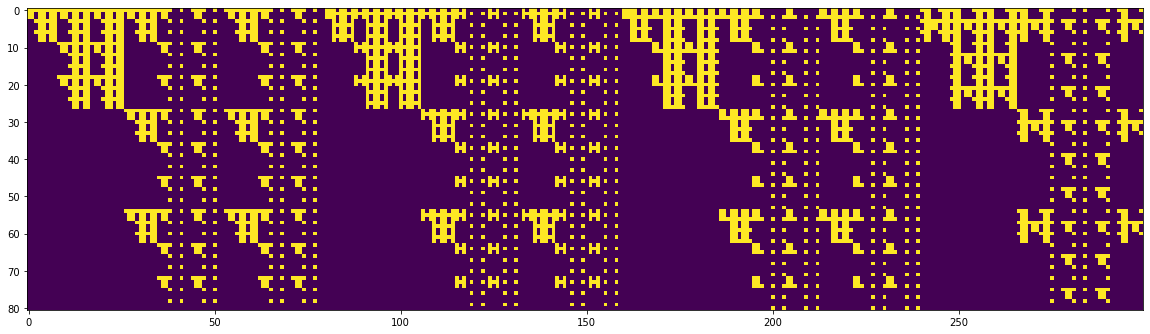

In [163]:
# all
plt.figure(figsize = (20,100))
plt.imshow((xy)[:, :300])

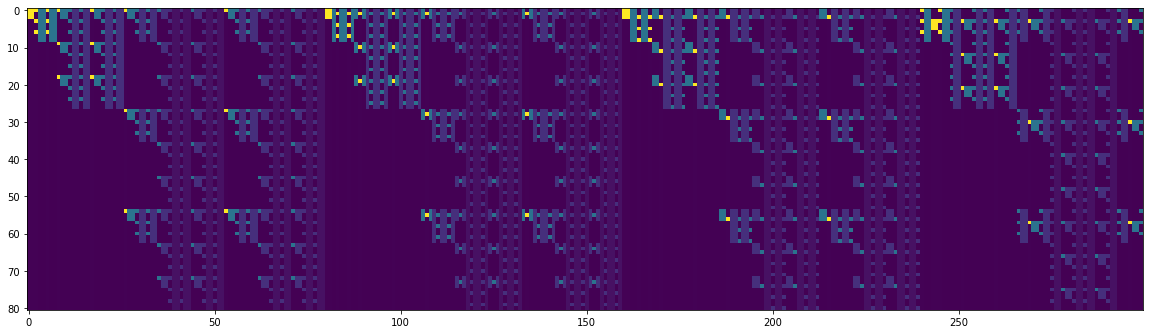

In [164]:
# all
plt.figure(figsize = (20,100))
plt.imshow((xy/xyind)[:, :300])

In [216]:
Counter(list(xy.reshape(-1))).most_common()

[(9.50129597677123e-08, 435456), (1.0720008460719617e-05, 89424)]

In [220]:
# Seen
seen_count_table = np.zeros((len(cardgame_data['idx_to_card']), len(cardgame_data['cardpair_to_idx'])))
for idx in cardgame_data['seen_cardpair_indices']:
     seen_count_table[:, idx] = count_table[:, idx]

seen_xy = np.zeros((len(cardgame_data['idx_to_card']), len(cardgame_data['cardpair_to_idx']))) 
for idx in cardgame_data['seen_cardpair_indices']:
     seen_xy[:, idx] = xy[:, idx]
        
seen_xy /= np.sum(seen_xy)

seen_x = np.sum(seen_xy,0)
seen_y = np.sum(seen_xy,1)
seen_xyind = seen_y[None].T @ seen_x[None]

In [219]:
Counter(list(seen_xy.reshape(-1))).most_common()

[(9.656158781467275e-08, 428793), (1.0894735211749273e-05, 87987), (0.0, 8100)]

In [202]:
6380 * 81

516780

In [221]:
np.sum(seen_count_table)

87987.0

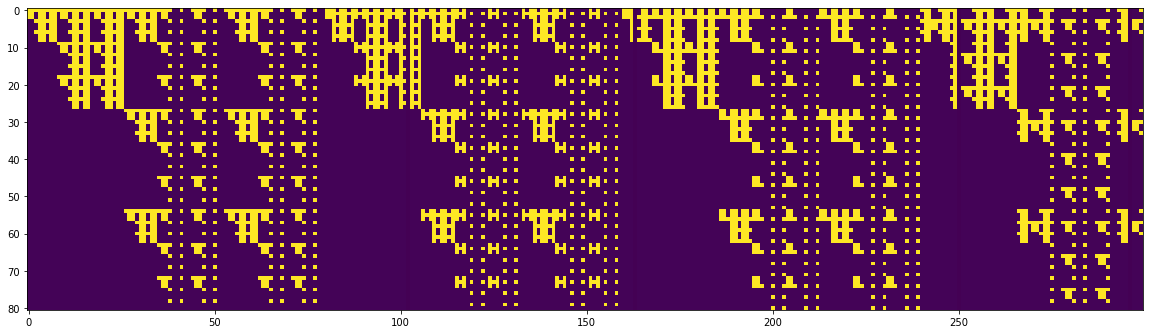

In [222]:
# seen
plt.figure(figsize = (20,100))
plt.imshow((seen_xy)[:, :300])

<ipython-input-223-8392788c0132>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((seen_xy/seen_xyind)[:, :300])


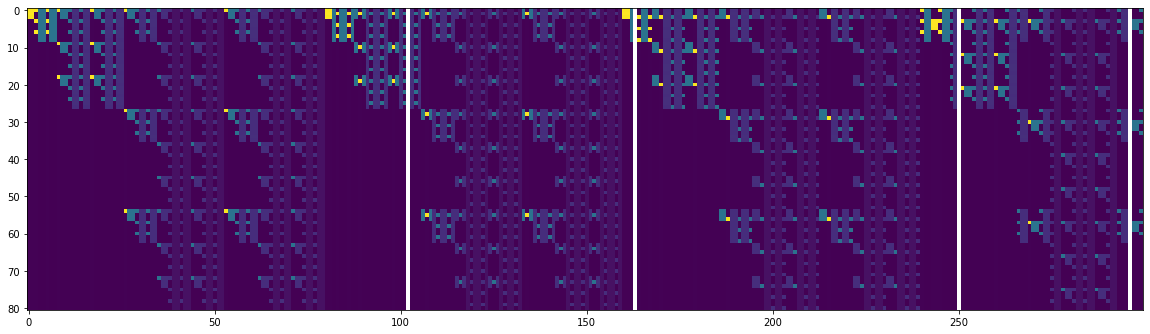

In [223]:
# seen
plt.figure(figsize = (20,100))
plt.imshow((seen_xy/seen_xyind)[:, :300])

In [224]:
# Unseen
unseen_count_table = np.zeros((len(cardgame_data['idx_to_card']), len(cardgame_data['cardpair_to_idx'])))
for idx in cardgame_data['unseen_cardpair_indices']:
     unseen_count_table[:, idx] = count_table[:, idx]

unseen_xy = np.zeros((len(cardgame_data['idx_to_card']), len(cardgame_data['cardpair_to_idx']))) 
for idx in cardgame_data['unseen_cardpair_indices']:
     unseen_xy[:, idx] = xy[:, idx]
        
unseen_xy /= np.sum(unseen_xy)

unseen_x = np.sum(unseen_xy,0)
unseen_y = np.sum(unseen_xy,1)
unseen_xyind = unseen_y[None].T @ unseen_x[None]

In [227]:
np.sum(unseen_count_table)

1437.0

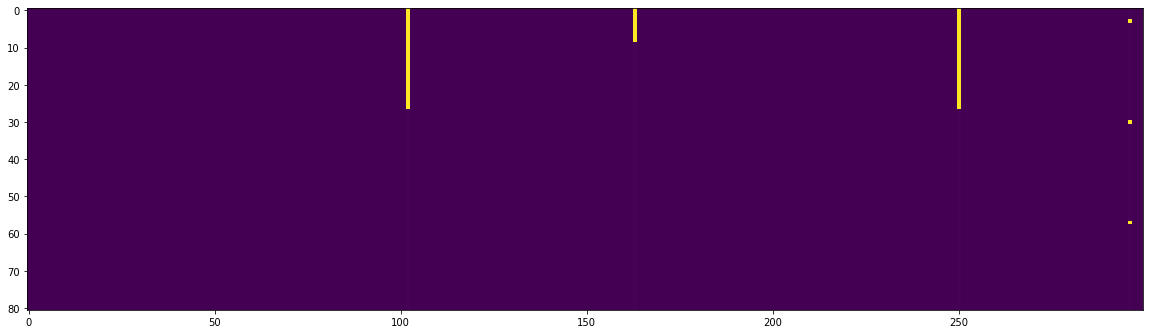

In [225]:
# seen
plt.figure(figsize = (20,100))
plt.imshow((unseen_xy)[:, :300])

<ipython-input-226-4f5574f57fd6>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((unseen_xy/unseen_xyind)[:, :300])


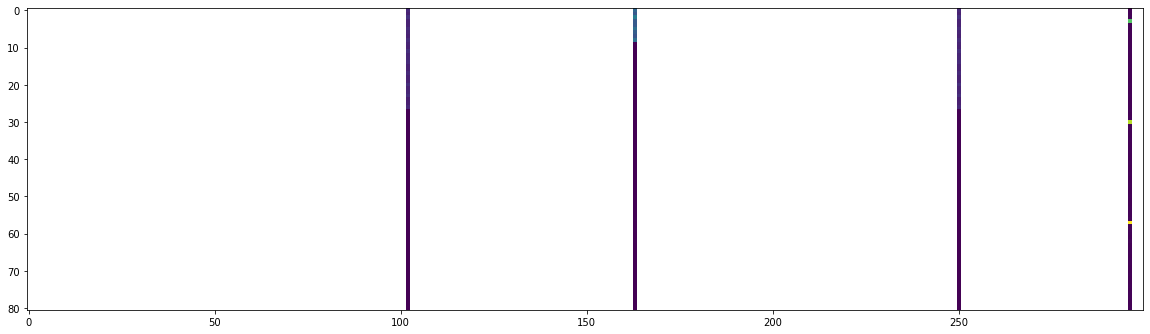

In [226]:
# seen
plt.figure(figsize = (20,100))
plt.imshow((unseen_xy/unseen_xyind)[:, :300])

In [228]:
# split train and val
num_val = 1000

# position in matrix
all_seen_matrix_indices = list(itertools.product(*[cardgame_data['seen_cardpair_indices'], range(81)]))
# flattened
val_seen_ix = np.random.choice(len(all_seen_matrix_indices), size=num_val)
# flattened
train_seen_ix = [i for i in range(len(all_seen_matrix_indices)) if i not in val_seen_indices]
# position in matrix
val_seen_matrix_indices = [all_seen_matrix_indices[i] for i in val_seen_ix]
# position in matrix
train_seen_matrix_indices = [all_seen_matrix_indices[i] for i in train_seen_ix]

In [229]:
print(len(train_seen_matrix_indices))
print(len(val_seen_matrix_indices))

515782
1000


In [230]:
# Seen train
seen_train_count_table = np.zeros((len(cardgame_data['idx_to_card']), len(cardgame_data['cardpair_to_idx'])))
for i, j in train_seen_matrix_indices:
    seen_train_count_table[j, i] = seen_count_table[j, i]

seen_train_xy = np.zeros((len(cardgame_data['idx_to_card']), len(cardgame_data['cardpair_to_idx']))) 
for i, j in train_seen_matrix_indices:
     seen_train_xy[j, i] = seen_xy[j, i]
    
# seen_train_xy = seen_train_count_table/np.sum(seen_train_count_table)
seen_train_xy /= np.sum(seen_train_xy)

seen_train_x = np.sum(seen_train_xy,0)
seen_train_y = np.sum(seen_train_xy,1)
seen_train_xyind = seen_train_y[None].T @ seen_train_x[None]

In [236]:
Counter(list(seen_train_xy.reshape(-1))).most_common()

[(9.673176677405527e-08, 427949), (1.0913935959614378e-05, 87833), (0.0, 9098)]

In [231]:
np.sum(seen_train_count_table)

87833.0

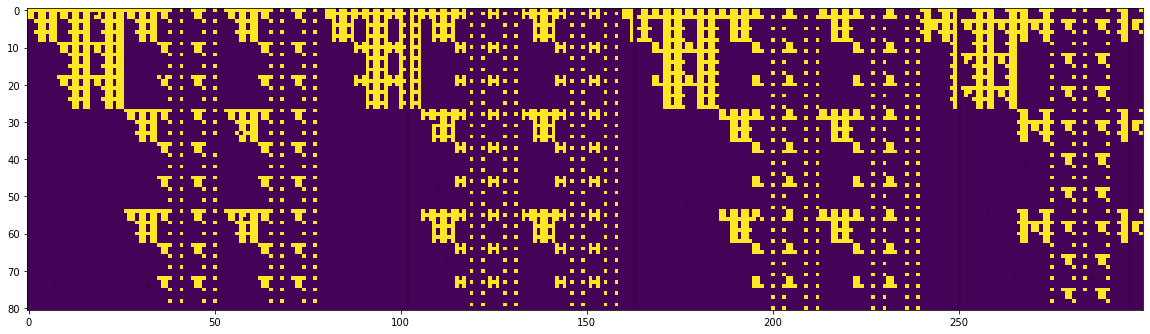

In [232]:
# seen_filled
plt.figure(figsize = (20,100))
plt.imshow((seen_train_xy)[:, :300])

<ipython-input-233-813a7a9c9924>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((seen_train_xy/seen_train_xyind)[:, :300])


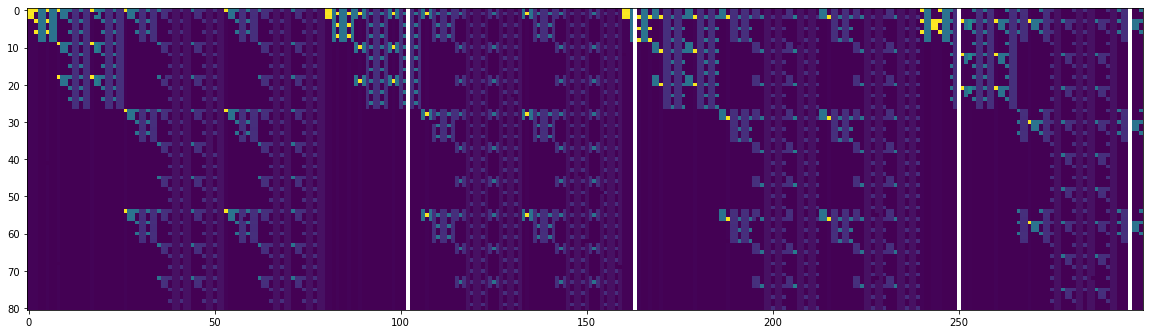

In [233]:
# seen_filled
plt.figure(figsize = (20,100))
plt.imshow((seen_train_xy/seen_train_xyind)[:, :300])

In [234]:
# seen val
seen_val_count_table = np.zeros((len(cardgame_data['idx_to_card']), len(cardgame_data['cardpair_to_idx'])))
for i, j in val_seen_matrix_indices:
    seen_val_count_table[j, i] = seen_count_table[j, i]

seen_val_xy = np.zeros((len(cardgame_data['idx_to_card']), len(cardgame_data['cardpair_to_idx']))) 
for i, j in val_seen_matrix_indices:
     seen_val_xy[j, i] = seen_xy[j, i]
    
# seen_val_xy = seen_val_count_table/np.sum(seen_val_count_table)
seen_val_xy /= np.sum(seen_val_xy)

seen_val_x = np.sum(seen_val_xy,0)
seen_val_y = np.sum(seen_val_xy,1)
seen_val_xyind = seen_val_y[None].T @ seen_val_x[None]

In [235]:
Counter(list(seen_val_xy.reshape(-1))).most_common()

[(0.0, 523881), (4.915203678292543e-05, 826), (0.00554566715385725, 173)]

In [197]:
np.sum(seen_val_count_table)

177.0

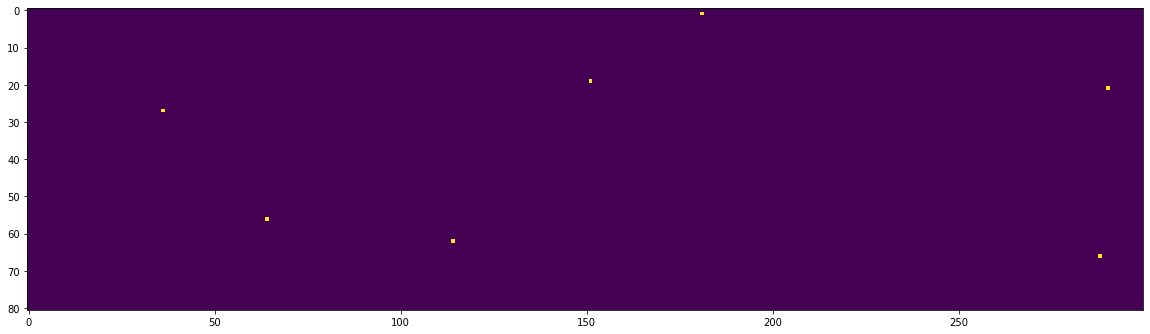

In [194]:
# seen_filled
plt.figure(figsize = (20,100))
plt.imshow((seen_val_xy)[:, :300])

<ipython-input-195-30e0e8f7f1b6>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((seen_val_xy/seen_val_xyind)[:, :300])


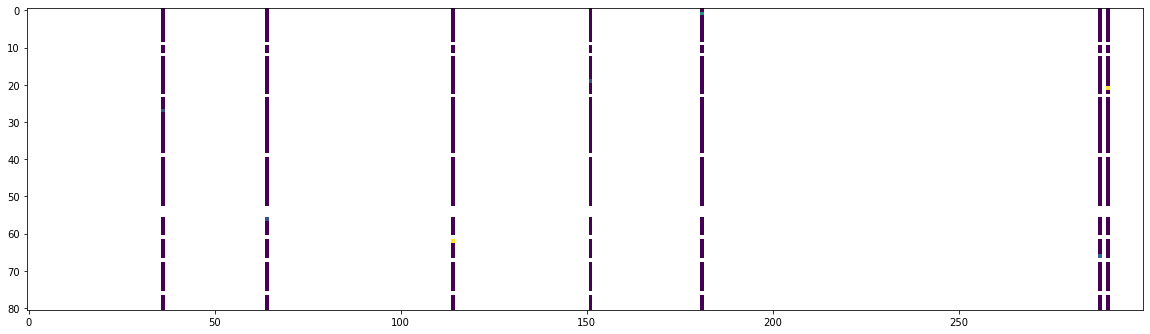

In [195]:
# seen_filled
plt.figure(figsize = (20,100))
plt.imshow((seen_val_xy/seen_val_xyind)[:, :300])

In [ ]:
# How to split between train and val?

# How to sample datapoints?
# Build full matrix count xy first.
# Throw away all the unseen query columns.
# Randomly select 500 positions as val set. (100 real matches, 400 fake matches). Sample a 1000 matrices from this distribution for validation.
# Remaining are 516280 training positions. Everytime we train just sample a batch from this distribution.
# 

# ToDo Make visualization to explain this train-val first.

# Make visualization to explain testing.

In [ ]:
# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers

In [ ]:
# ToDo

# dataset -- nothing special with sampler. Just fix the indices and return the tensors
# dataloader -- need to write sampler for it. (weighted, weighted_ddp)
# datamodule -- nothing special, just intiate the dataloader inside
# lightning trainer -- need to disable sampler_ddp

In [ ]:
# Torch Dataset class

# Need a data sampler to do this?

# dataset
# dataloader

# DataModule (use dataset to make dataloader)

class CardGameDataset(Dataset):
    
    def __init__(self, raw_data, seed, debug=False):
        '''
        Train / Val only?
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        np.random.seed(seed)
        self.raw_data = raw_data
        self.debug = debug
        
    def __len__(self):
        return len(self.X_scenes)
    
    def __getitem__(self, key_idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=6480) + (xy_j)
        '''
        xy_i, xy_j = key_idx//xy.shape[1], key_idx%xy.shape[1]

In [237]:
seen_val_xy.shape

(81, 6480)

In [240]:
dum = np.array([[1,2,3], [10,11,12]])
print(dum)
print(dum.shape)
dum.reshape(-1)

[[ 1  2  3]
 [10 11 12]]
(2, 3)


array([ 1,  2,  3, 10, 11, 12])

In [248]:
dum.reshape(-1)[1 * 3 + 2]

12

In [249]:
dum.reshape(-1)[5]

12

In [250]:
5//3

1

In [251]:
5%3

2

In [ ]:
# Lightning DataModule class

In [ ]:
## ToDo Becareful about cloning
## Ans. Use a different construct_full_model() call to untie everything
## Clone Layers? -- leave it
## Clone pff? -- 
## Clone others?

## Lookup which layernorm we are using

# Deal with B and b -- leave it until more experiments are run on 20210127 InfoNCE with revised metric
# Deal with LR schedule

## skipped
# class LRScheduledAdam(Optimizer):
# gradient clipping (lightning call)

# Data
# Vocab
# embeddings -- different vocab for query tokens vs key tokens?
# What are the tokens?
# use CLS token

# hparams
# Becareful of
# max_len, vocab_size, padding_idx, 


In [ ]:
## W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


hparams = {
    'batch_size': 128,
    'gradient_clip_val': 0.0,
    'd_model': 32,
    'd_ff': 1024,
    'max_len': 501, #!
    'num_heads': 1,
    'embed_dropout': 0.0,
    # Attention
    'attn_wt_dropout': 0.0,
    'attn_wt_init_tying_scheme': 'untie_QK_zeroO', # tie_all, untie_all, untie_QK, _zeroO
    'heads_dropout': 0.0,
    'pff_dropout': 0.0,
    # Layers
    'N_enc': 3,
    # Loss
    'loss_temperature_const': 1.0,
    # LR
    'lr_decay_step_size': 5,
    'lr_decay_gamma': 0.1,
    'adam_beta1': 0.9,
    'adam_beta2': 0.98,
    'adam_epsilon': 1e-9,
    'warmup_steps': 24000,
    # Vocab, Padding
    'vocab_size': 3,#!
    'padding_idx_query': 3,#! 
    'padding_idx_key': 3,#! 
    'use_CLS_token': True,
    'representation_pos': 0 # which position to use for repr vector
}


# model
my_transformer = Transformer(hparams)
print(pl.core.memory.ModelSummary(my_transformer, mode='full'),'\n')

# data
cardgame_data = gen_card_data(attributes, attr_order, num_unseen_cardpairs=100, debug=False)

# datamodule
cardgame_datamodule = CardGameDataModule(
    batch_size = hparams['batch_size'],
    data = cardgame_data
)

# logger 
# wd_logger = WandbLogger(name="",project='ContrastiveLearning-CardGame1')
wd_logger = WandbLogger(name="test-dummy",project='ContrastiveLearning-CardGame1')

# trainer
trainer = pl.Trainer(
    gpus=[1], min_epochs=2, max_epochs=10000, 
    logger=wd_logger,log_gpu_memory='all',
    precision=32, gradient_clip_val=hparams['gradient_clip_val'])

# fit!
with torch.autograd.detect_anomaly():
    trainer.fit(my_transformer, countOnes_data)